In [13]:
import nibabel as nib
import matplotlib.pyplot as plt 
from matplotlib import patches
import numpy as np
import re
import os
import cv2

In [14]:
def load_nifti_image(file_path):
    img = nib.load(file_path)
    img_data = img.get_fdata()
    return img_data

# Site 1

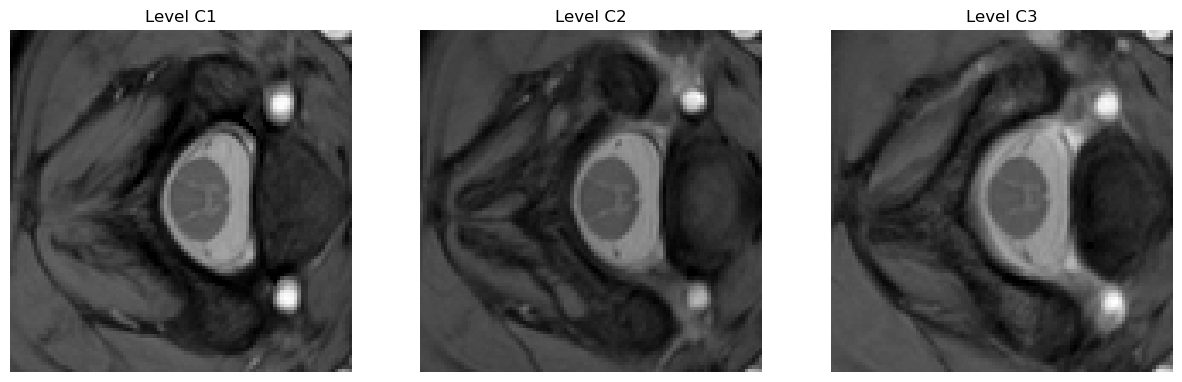

In [15]:
img_test = load_nifti_image('./train/site1-sc01-image.nii.gz')
plt.figure(figsize=(15,6))
for k in range(3):
    plt.subplot(1,3,k+1)
    plt.imshow(img_test[:,:,k], cmap='gray')
    plt.axis('off')
    plt.title(f'Level C{k+1}')

Site 2

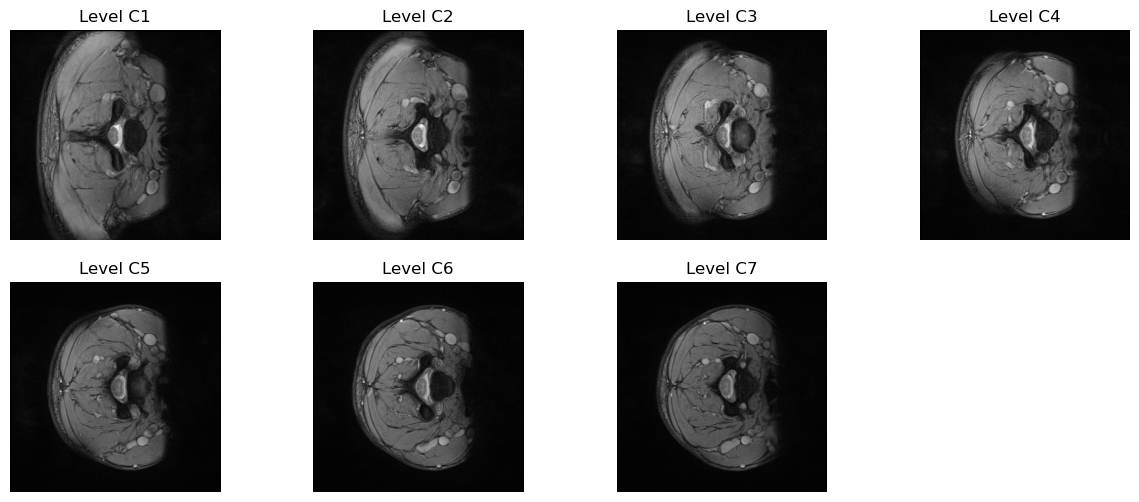

In [16]:
img_test = load_nifti_image('./train/site2-sc06-image.nii.gz')
plt.figure(figsize=(15,6))
for k in range(7):
    plt.subplot(2,4,k+1)
    plt.imshow(img_test[:,:,k], cmap='gray')
    plt.axis('off')
    plt.title(f'Level C{k+1}')

Site 3

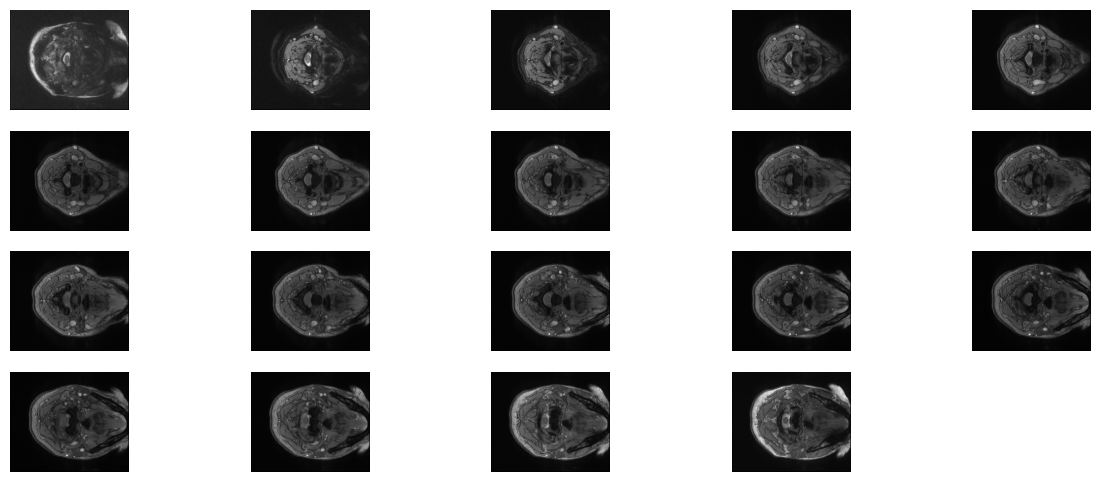

In [17]:
img_test = load_nifti_image('./train/site3-sc01-image.nii.gz')
img_test.shape
plt.figure(figsize=(15,6))
for k in range(4,23):
    plt.subplot(4,5,k-3)
    plt.imshow(img_test[:,:,k], cmap='gray')
    plt.axis('off')

Site 4

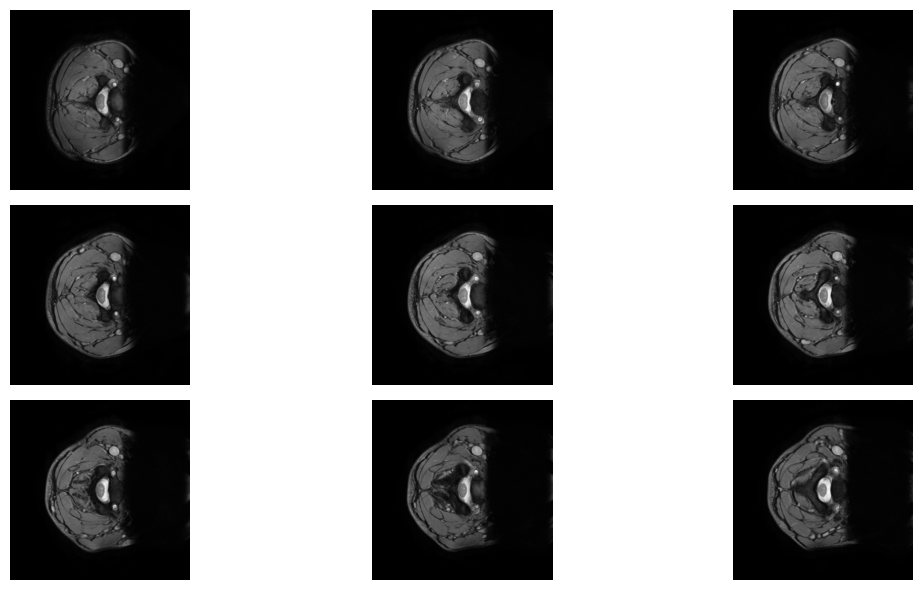

In [18]:
img_test = load_nifti_image('./train/site4-sc02-image.nii.gz')
img_test.shape
plt.figure(figsize=(15,6))
for k in range(3,12):
    plt.subplot(3,3,k-2)
    plt.imshow(img_test[:,:,k], cmap='gray')
    plt.axis('off')
    plt.tight_layout()

In [19]:
def convert_mask_into_gray_matter(mask):
    segmented_mask = np.zeros(mask.shape)
    for x in range(mask.shape[0]):
        for y in range(mask.shape[1]):
            if mask[x,y] == 1:
                segmented_mask[x,y] = 1
            else:
                pass 
    indices = np.argwhere(mask == 1)
    xmin = np.min(indices[:,1])
    xmax = np.max(indices[:,1])
    ymin = np.max(indices[:,0])
    ymax = np.min(indices[:,0])
    return segmented_mask, (xmin, xmax-xmin, ymax, ymin-ymax)

In [20]:
def crop_image_around_the_mask(img, mask, SIZE_SQUARE=150, max_shift=60):
    gm_mask, (x, w, y, h) = convert_mask_into_gray_matter(mask)
    width_to_add = round((SIZE_SQUARE - w) / 2)
    height_to_add = round((SIZE_SQUARE - h) / 2)
    
    shift_x = np.random.randint(-max_shift, max_shift)
    shift_y = np.random.randint(-max_shift, max_shift)
    
    y_min = max(0, y - height_to_add + shift_y)
    y_max = min(img.shape[0], y + height_to_add + h + shift_y)
    x_min = max(0, x - width_to_add + shift_x)
    x_max = min(img.shape[1], x + width_to_add + w + shift_x)
    if (y_max - y_min) != SIZE_SQUARE:
        if y_min == 0:
            y_max = SIZE_SQUARE
        else:
            y_min = y_max - SIZE_SQUARE
    if (x_max - x_min) != SIZE_SQUARE:
        if x_min == 0:
            x_max = SIZE_SQUARE
        else:
            x_min = x_max - SIZE_SQUARE
            
    cropped_img = img[y_min:y_max, x_min:x_max]
    cropped_mask = gm_mask[y_min:y_max, x_min:x_max]
    return cropped_img, cropped_mask


(-0.5, 149.5, 149.5, -0.5)

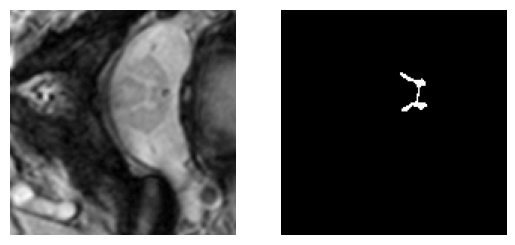

In [21]:
img_test_bis = load_nifti_image('./train/site3-sc01-image.nii.gz')[:,:,14]
mask_test_bis = load_nifti_image('./train/site3-sc01-mask-r1.nii.gz')[:,:,14]
cropped_img, cropped_mask = crop_image_around_the_mask(img_test_bis, mask_test_bis)
plt.subplot(1,2,1)
plt.imshow(cropped_img, cmap='gray')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(cropped_mask, cmap='gray')
plt.axis('off')

In [22]:
def get_levels(filename):
    list_levels = []
    with open(filename, 'r') as file:
        lines = file.readlines()
    for line in lines[1:]:
        try:
            levels_in_file = re.findall('(,)(.*)', line)[0][1]
            list_levels.append(int(levels_in_file.strip()[0]))
        except:
            list_levels.append(None)
    return list_levels

In [37]:
dict_filepaths={}
filename_img = []
filename_levels = []
filename_masks = []
for site_index in range(1,5):
    for irm_index in range(1,11):
        if irm_index < 10:
            name_index = '0' + str(irm_index)
        else:
            name_index = '10'
        filename_img.append('./train/site'+str(site_index)+'-sc'+name_index+'-image.nii.gz')
        filename_levels.append('./train/site'+str(site_index)+'-sc'+name_index+'-levels.txt')
        filename_masks.append(['./train/site'+str(site_index)+'-sc'+name_index+'-mask-r'+str(i)+'.nii.gz' for i in range(1,5)])

In [40]:
for k in range(len(filename_img)):
    dict_filepaths['MRI'+str(k)]={
            'site' : int(filename_img[k][12:13]),
            'filename_img' : filename_img[k],
            'filename_levels' : filename_levels[k],
            'filename_masks' : filename_masks[k]
    }

In [41]:
dict_filepaths['MRI0']

{'site': 1,
 'filename_img': './train/site1-sc01-image.nii.gz',
 'filename_levels': './train/site1-sc01-levels.txt',
 'filename_masks': ['./train/site1-sc01-mask-r1.nii.gz',
  './train/site1-sc01-mask-r2.nii.gz',
  './train/site1-sc01-mask-r3.nii.gz',
  './train/site1-sc01-mask-r4.nii.gz']}

In [42]:
def display_image_and_its_mask(img, mask):
    img_normalized = np.copy(img) / np.max(img)
    img_with_mask = np.copy(img_normalized)
    for x in range(img.shape[0]):
        for y in range(img.shape[1]):
            if mask[x,y]==1:
                img_with_mask[x,y]=1
            else:
                pass
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.imshow(img_normalized, cmap='gray')
    plt.axis('off')
    plt.title('Base image')

    plt.subplot(1,2,2)
    plt.imshow(img_with_mask, cmap='gray')
    plt.axis('off')
    plt.title('Image with mask')

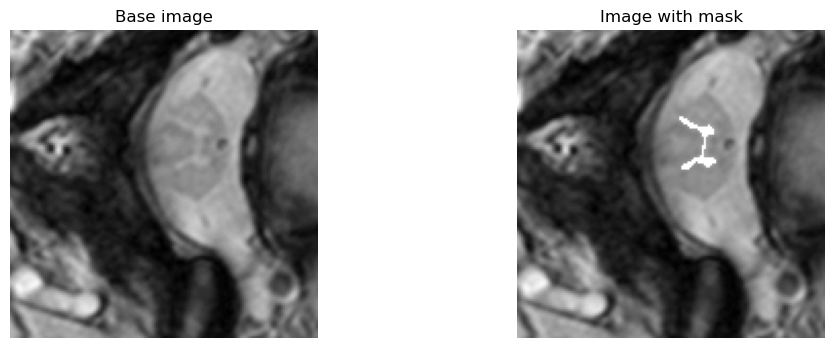

In [43]:
display_image_and_its_mask(cropped_img, cropped_mask)

In [44]:
def remove_null_image(mri, levels):
    levels_without_none = []
    mri_without_null = []
    for i in range(len(levels)):
        if levels[i] is None:
            pass
        else:
            levels_without_none.append(levels[i])
            mri_without_null.append(mri[:,:,i])
    return np.moveaxis(np.array(mri_without_null), 0, -1), levels_without_none

In [118]:
def remove_null_image(mri, mask, levels):
    (x,y,_) = mri.shape
    levels_without_none = []
    mri_without_null = []
    mask_without_null = []
    for i in range(len(levels)):
        if levels[i] is None or np.array_equal(mask[:,:,i], np.zeros((x,y))):
            pass
        else:
            levels_without_none.append(levels[i])
            mri_without_null.append(mri[:,:,i])
            mask_without_null.append(mask[:,:,i])
    return np.moveaxis(np.array(mri_without_null), 0, -1), np.moveaxis(np.array(mask_without_null), 0, -1), levels_without_none

In [76]:
mri = load_nifti_image('./train/site3-sc08-image.nii.gz')
levels = get_levels('./train/site3-sc08-levels.txt')
mri_formated, levels_formated = remove_null_image(mri, levels)
print(mri.shape, levels)

(654, 776, 27) [None, None, None, None, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, None, None, None, None]


In [73]:
np.array_equal(mri[:,:,4], mri_formated[:,:,0])

True

In [47]:
test = './train/site3-sc01-image.nii.gz'

In [125]:
def load_mri_slices(dict_filepaths, MRI_index, mask_index):
    name_mri = 'MRI'+str(MRI_index)
    mri = load_nifti_image(dict_filepaths[name_mri]['filename_img'])
    levels = get_levels(dict_filepaths[name_mri]['filename_levels'])
    mask = load_nifti_image(dict_filepaths[name_mri]['filename_masks'][mask_index])
    mri_formated, mask_formated, levels_formated = remove_null_image(mri, mask, levels)
    return mri_formated, mask_formated, levels_formated

In [126]:
mri_test, mask_test, levels_test = load_mri_slices(dict_filepaths, 11, 2)

In [127]:
mask_test.shape

(320, 320, 12)

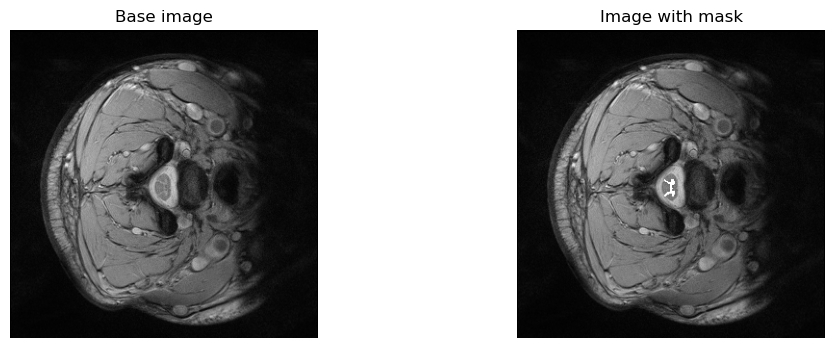

In [128]:
display_image_and_its_mask(mri_test[:,:,4], mask_test[:,:,4])

In [131]:
MRI_SLICES_PATH = './data_formated/MRI_slices/'
MASK_SLICES_PATH = './data_formated/masks_slices/'
def save_slice_as_single_file(dict_filepaths, index, filepath_slices_mri = MRI_SLICES_PATH, filepath_slices_masks = MASK_SLICES_PATH):
    mask_index = np.random.randint(0,4)
    mri, mask, levels = load_mri_slices(dict_filepaths, index, mask_index)
    os.makedirs(filepath_slices_mri, exist_ok=True)
    os.makedirs(filepath_slices_masks, exist_ok=True)
    (_,_,nb_slices) = mri.shape
    for i in range(nb_slices):
        mask_slice = mask[:,:,i]
        mri_slice = mri[:,:,i]
        mri_slice_formated, mask_slice_formated = crop_image_around_the_mask(mri_slice, mask_slice)
        np.save(os.path.join(filepath_slices_mri, f'IRM{index}_slice_{i}.npy'), mri_slice)
        np.save(os.path.join(filepath_slices_masks, f'Mask{index}_slice_{i}.npy'), mask_slice)

In [133]:
for mri_index_in_dict in range(len(dict_filepaths)):
    print(mri_index_in_dict)
    save_slice_as_single_file(dict_filepaths, mri_index_in_dict)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


ValueError: zero-size array to reduction operation minimum which has no identity

In [93]:
mask.shape

(320, 320, 12)

In [101]:
mri, mask, levels = load_mri_slices(dict_filepaths, 20, 1)

In [102]:
mri.shape

(654, 774, 20)

In [103]:
for i in range(20):
        print('nb_slice : ', nb_slices)
        print('mask_shape : ', mask.shape)
        mask_slice = mask[:,:,i]
        mri_slice = mri[:,:,i]
        mri_slice_formated, mask_slice_formated = crop_image_around_the_mask(mri_slice, mask_slice)

nb_slice :  12
mask_shape :  (654, 774, 20)


ValueError: zero-size array to reduction operation minimum which has no identity

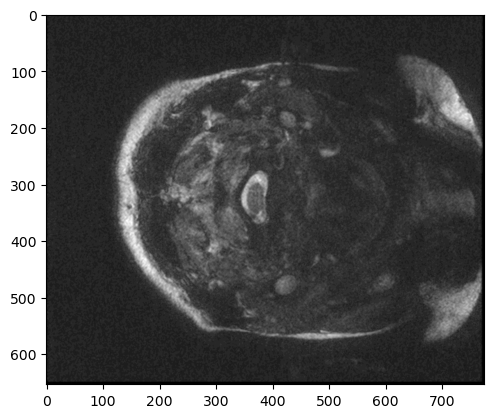

In [108]:
plt.imshow(mri_slice, cmap='gray')

In [114]:
mri.shape

(654, 774, 20)

In [150]:
# mask_index = np.random.randint(0,4)
mri, mask, levels = load_mri_slices(dict_filepaths, 20, 2)
mask.shape

(654, 774, 20)

In [152]:
# plt.imshow(mask[:,:,0])
np.array_equal(mask[:,:,0], np.zeros((654, 774)))

False